# Customer segmentation

You are the owner of a shop. It doesn't matter if you own an e-commerce or a supermarket. It doesn't matter if it is a small shop or a huge company such as Amazon or Netflix, it's better to know your customers.

You were able to collect basic data about your customers holding a membership card such as Customer ID, age, gender, annual income, and spending score. This last one is a score based on customer behavior and purchasing data. There are some new products on the market that you are interested in selling. But you want to target a specific type of clients for each one of the products.

Machine learning comes in handy for this task. Particularly, clustering, the most important unsupervised learning problem, is able to create categories grouping similar individuals. These categories are called clusters. A cluster is a collection of points in a dataset. These points are more similar between them than they are to points belonging to other clusters. Distance-based clustering groups the points into some number of clusters such that distances within the cluster should be small while distances between clusters should be large.

# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
customers = pd.read_csv('customers.csv')
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Exploring the Data

In [3]:
customers.shape

(200, 5)

In [4]:
customers.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
customers.duplicated().sum()

0

In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
customers.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


<AxesSubplot:>

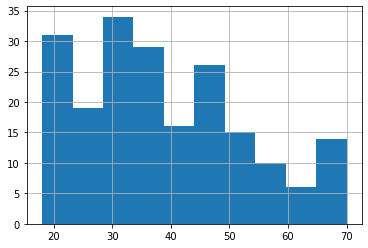

In [8]:
customers.Age.hist()

<AxesSubplot:>

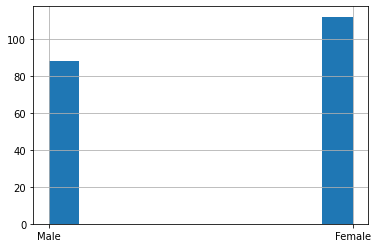

In [9]:
customers.Gender.hist()

<AxesSubplot:xlabel='Gender', ylabel='count'>

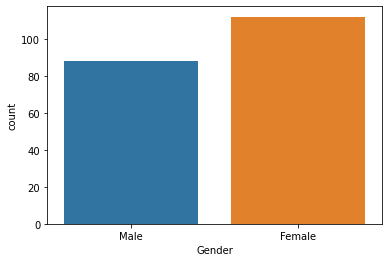

In [10]:
sns.countplot(x = 'Gender', data = customers)

In [11]:
annual_income = customers['Annual Income (k$)']

In [12]:
spending_score = customers['Spending Score (1-100)']

<AxesSubplot:xlabel='Gender', ylabel='Age'>

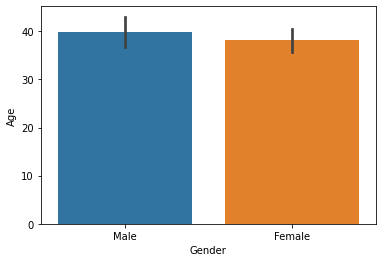

In [13]:
sns.barplot(x = 'Gender', y = 'Age', data = customers)

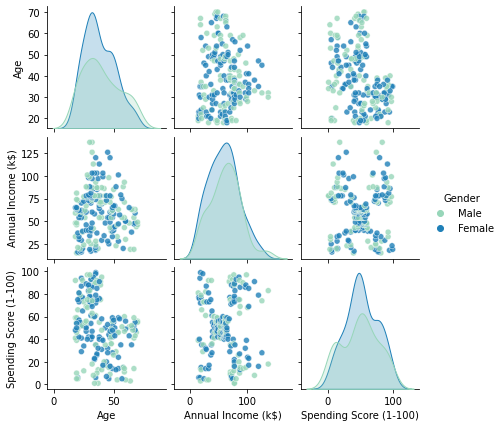

In [18]:
sns.pairplot(customers, x_vars = ["Age", "Annual Income (k$)", "Spending Score (1-100)"], 
               y_vars = ["Age", "Annual Income (k$)", "Spending Score (1-100)"], 
               hue = "Gender", 
               kind= "scatter",
               palette = "YlGnBu",
               height = 2,
               plot_kws={"s": 35, "alpha": 0.8});

# Dimensionality reduction

After we checked that we can apply k-means, we can apply Principal Component Analysis (PCA) to discover which dimensions best maximize the variance of features involved.

## Principal Component Analysis (PCA)

First, we'll transform the categorical variable into two binary variables.

In [19]:
customers["Male"]   = customers.Gender.apply(lambda x: 0 if x == "Male" else 1)
customers["Female"] = customers.Gender.apply(lambda x: 0 if x == "Female" else 1)

In [20]:
X = customers.iloc[:, 2:]

In [21]:
X.head()

,Age,Annual Income (k$),Spending Score (1-100),Male,Female
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0


In [22]:
# Apply PCA and fit the features selected
pca = PCA(n_components=2).fit(X)

During the fitting process, the model learns some quantities from the data: the "components" and "explained variance".

In [23]:
print(pca.components_)

[[-1.88980385e-01  5.88604475e-01  7.86022241e-01  3.32880772e-04
  -3.32880772e-04]
 [ 1.30957602e-01  8.08400899e-01 -5.73875514e-01 -1.57927017e-03
   1.57927017e-03]]


In [24]:
print(pca.explained_variance_)

[700.26450987 684.33354753]


These numbers that appear to be abstract define vectors. The components define the direction of the vector while the explained variance define the squared-length of the vector.

The vectors represent the principal axes of the data. The length of the vector indicates the importance of that axis in describing the distribution of the data. The projection of each data point onto the principal axes are the principal components of the data.

In [25]:
# Transform samples using the PCA fit
pca_2d = pca.transform(X)

# K-Means clustering

In order to cluster data, we need to determine how to tell if two data points are similar. A proximity measure characterizes the similarity or dissimilarity that exists between objects.

We can choose to determine if two points are similar. So if the value is large, the points are very similar. Or choose to determine if they are dissimilar. If the value is small, the points are similar. This is what we know as "distance".

There are various distances that a clustering algorithm can use: Manhattan distance, Minkowski distance, Euclidean distance, among others.


K-means typically uses Euclidean distance to determine how similar (or dissimilar) two points are.

First, we need to fix the numbers of clusters to use.

There are several direct methods to perform this. Among them, we find the elbow and silhouette methods.

We'll consider the total intra-cluster variation (or total within-cluster sum of square (WSS)). The goal is to minimize WSS.

The Elbow method looks at how the total WSS varies with the number of clusters.  For that, we'll compute k-means for a range of different values of k. Then, we calculate the total WSS. We plot the curve WSS vs. number of clusters.  Finally, we locate the elbow or bend of the plot. This point is considered to be the appropriate number of clusters.

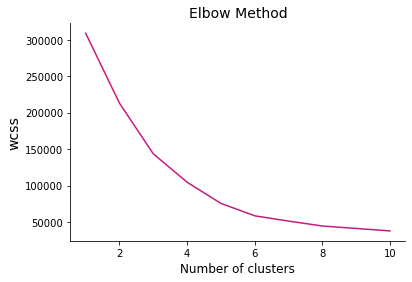

In [33]:
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show() 

How does k-means clustering works? The main idea is to select k centers, one for each cluster. There are several ways to initialize those centers. We can do it randomly, pass certain points that we believe are the center or place them in a smart way (e.g. as far away from each other as possible). Then, we calculate the Euclidean distance between each point and the cluster centers. We assign the points to the cluster center where the distance is minimum. After that, we recalculate the new cluster center. We select the point that is in the middle of each cluster as the new center.  And we start again, calculate distance, assign to cluster, calculate new centers. When do we stop? When the centers do not move anymore.

In [34]:
# Kmeans algorithm
# n_clusters: Number of clusters. In our case 5
# init: k-means++. Smart initialization
# max_iter: Maximum number of iterations of the k-means algorithm for a single run
# n_init: Number of time the k-means algorithm will be run with different centroid seeds. 
# random_state: Determines random number generation for centroid initialization.
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=0)

# Fit and predict 
y_means = kmeans.fit_predict(X)

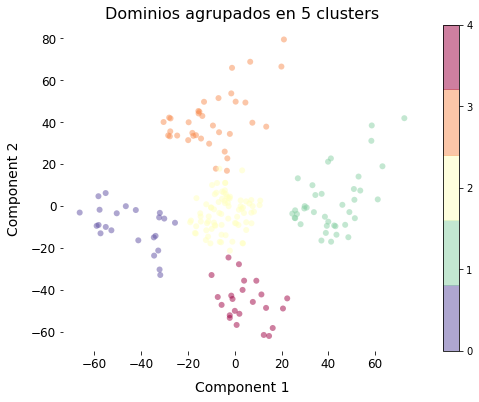

In [35]:
fig, ax = plt.subplots(figsize = (8, 6))

plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
            c=y_means, 
            edgecolor="none", 
            cmap=plt.cm.get_cmap("Spectral_r", 5),
            alpha=0.5)
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Component 1", size = 14, labelpad=10)
plt.ylabel("Component 2", size = 14, labelpad=10)

plt.title('Dominios agrupados en 5 clusters', size=16)


plt.colorbar(ticks=[0, 1, 2, 3, 4]);

plt.show()

In [36]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ["Age", "Annual Income", "Spending", "Male", "Female"])
centroids.index_name = "ClusterID"
centroids["ClusterID"] = centroids.index
centroids = centroids.reset_index(drop=True)
centroids

,Age,Annual Income,Spending,Male,Female,ClusterID
0,45.217391,26.304348,20.913043,0.608696,0.391304,0
1,32.692308,86.538462,82.128205,0.538462,0.461538,1
2,43.088608,55.291139,49.569620,0.582278,0.417722,2
3,40.666667,87.750000,17.583333,0.472222,0.527778,3
4,25.521739,26.304348,78.565217,0.608696,0.391304,4


The most important features appear to be Annual Income and Spending score.  We have people whose income is low but spend in the same range - segment 0. People whose earnings a high and spend a lot - segment 1. Customers whose income is middle range but also spend at the same level - segment 2.  Then we have customers whose income is very high but they have most spendings - segment 4. And last, people whose earnings are little but they spend a lot- segment 5.

Imagine that tomorrow we have a new member. And we want to know which segment that person belongs. We can predict this.

In [37]:
X_new = np.array([[43, 76, 56, 0, 1]]) 
 
new_customer = kmeans.predict(X_new)
print(f"The new customer belongs to segment {new_customer[0]}")

The new customer belongs to segment 2
